# Machine Translation + Transformer

<img src = "../figures/transformer1.png" >

In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# torch.cuda.get_device_name(0)

In [3]:
torch.__version__

'2.1.1+cu118'

In [4]:
torchtext.__version__

'0.16.1+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [5]:
import datasets

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'th'

dataset = datasets.load_dataset("opus100", "en-th")

c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for opus100 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/opus100
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [6]:
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [7]:
from numpy.random import default_rng

rng = default_rng(seed=SEED)
# create a list of non-repeated indices of size 10000 and use it to select the training samples
select_idx = rng.choice(len(dataset['train']), size=1000, replace=False)
dataset['train'] = dataset['train'].filter(lambda example, idx: idx in select_idx, with_indices=True)

In [8]:
get_lang_col = lambda example, lang: {lang: example['translation'][lang]}
dataset = dataset.map(get_lang_col, fn_kwargs={'lang': "th"})
dataset = dataset.map(get_lang_col, remove_columns=['translation'], fn_kwargs={'lang': "en"})

In [9]:
dataset['train'][2]

{'th': '-ชั้นทำอยู่', 'en': '- I am blending.'}

In [10]:
dataset

DatasetDict({
    test: Dataset({
        features: ['th', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['th', 'en'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['th', 'en'],
        num_rows: 2000
    })
})

In [11]:
train, val, test = dataset['train'], dataset['test'], dataset['validation']

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [12]:
# !pip install pythainlp

In [13]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [14]:
from torchtext.data.utils import get_tokenizer
from pythainlp.tokenize import Tokenizer

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = Tokenizer(engine='newmm')

In [15]:
#example of tokenization of the thai part
print("Sentence: ", dataset['train'][TRG_LANGUAGE][2])
print("Tokenization: ", token_transform[TRG_LANGUAGE].word_tokenize(dataset['train'][TRG_LANGUAGE][2]))

Sentence:  -ชั้นทำอยู่
Tokenization:  ['-', 'ชั้น', 'ทำ', 'อยู่']


In [16]:
def tokenize_data(example, lang):
    try:
        return {lang: token_transform[lang](example[lang].lower())}
    except:
        return {lang: token_transform[lang].word_tokenize(example[lang].lower())}
    
tokenized_dataset = dataset.map(tokenize_data, remove_columns=[SRC_LANGUAGE], fn_kwargs={'lang': SRC_LANGUAGE})
tokenized_dataset = tokenized_dataset.map(tokenize_data, remove_columns=[TRG_LANGUAGE], fn_kwargs={'lang': TRG_LANGUAGE})

Map: 100%|██████████| 2000/2000 [00:00<00:00, 10810.79 examples/s]


In [17]:
tokenized_dataset['train'][0]

{'th': ['พระองค์',
  'คือ',
  'ผู้ทรง',
  'ประทาน',
  'คัมภีร์',
  'ลงมา',
  'แก่',
  'เจ้า',
  ' ',
  'โดยที่',
  'ส่วนหนึ่ง',
  'จาก',
  'คัมภีร์',
  'นั้น',
  'มี',
  'บรรดา',
  'โฮ',
  'ง',
  'การ',
  'ที่',
  'มี',
  'ข้อความ',
  'รัดกุม',
  'ชัดเจน',
  ' ',
  'ซึ่ง',
  'โองการ',
  'เหล่านั้น',
  ' ',
  'คือ',
  'รากฐาน',
  'ของ',
  'คัมภีร์',
  ' ',
  'และ',
  'มี',
  'โองการ',
  'อื่น',
  ' ',
  'ไ',
  ' ',
  'อีก',
  'ที่',
  'มี',
  'ข้อความ',
  'เป็นนัย',
  ' ',
  'ส่วน',
  'บรรดา',
  'ผู้',
  'ที่',
  'ใน',
  'หัวใจ',
  'ของ',
  'พวกเขา',
  'มี',
  'การ',
  'เอนเอียง',
  'ออกจาก',
  'ความจริง',
  'นั้น',
  ' ',
  'เขา',
  'จะ',
  'ติดตาม',
  'โองการ',
  'ที่',
  'มี',
  'ข้อความ',
  'เป็นนัย',
  'จาก',
  'คัมภีร์',
  ' ',
  'ทั้งนี้',
  ' ',
  'เพื่อ',
  'แสวงหา',
  'ความวุ่นวาย',
  ' ',
  'และ',
  'เพื่อ',
  'แสวงหา',
  'การ',
  'ตี',
  'ความใน',
  'โองการ',
  'นั้น',
  ' ',
  'แล',
  'ไม่',
  'มี',
  'ใคร',
  'รู้',
  'ใน',
  'การ',
  'ตีความ',
  'โองการ',
  'นั้น',
  'ได้

In [18]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [19]:
for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[lang] = torchtext.vocab.build_vocab_from_iterator(tokenized_dataset['train'][lang],
                                                                      min_freq=3,   #if not, everything will be treated as UNK
                                                                      specials=special_symbols,
                                                                      special_first=True) #indicates whether to insert symbols at the beginning or at the end)
    # Set UNK_IDX as the default index. This index is returned when the token is not found. 
    # If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
    vocab_transform[lang].set_default_index(UNK_IDX)

In [20]:
#see some example
vocab_transform[SRC_LANGUAGE](['my', 'precious'])

[40, 0]

In [21]:
#see some example
vocab_transform[TRG_LANGUAGE](['ของ', 'รัก', 'ของ', 'ข้า'])

[13, 202, 13, 78]

In [22]:
#we can reverse it....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

#print 1816, for example
mapping[13]

'ของ'

In [23]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [24]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [25]:
#check unique vocabularies
len(mapping)

458

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [26]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            try:
                txt_input = transform(txt_input)
            except TypeError:
                txt_input = transform.word_tokenize(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](sample[SRC_LANGUAGE].rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](sample[TRG_LANGUAGE].rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [27]:
batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [28]:
for en, _, th in train_loader:
    break

In [29]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Thai shape: ", th.shape)   # (batch_size, seq len)

English shape:  torch.Size([19, 32])
Thai shape:  torch.Size([28, 32])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Seq2Seq

In [242]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device  = device
        
    def create_mask(self, src):
        #src: [src len, batch_size]
        mask = (src == self.src_pad_idx).permute(1, 0)  #permute so that it's the same shape as attention
        #mask: [batch_size, src len] #(0, 0, 0, 0, 0, 1, 1)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        #src: [src len, batch_size]
        #trg: [trg len, batch_size]
        
        #initialize something
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs    = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #send our src text into encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs refer to all hidden states (last layer)
        #hidden refer to the last hidden state (of each layer, of each direction)
        
        input_ = trg[0, :]
        
        mask   = self.create_mask(src) #(0, 0, 0, 0, 0, 1, 1)
        
        #for each of the input of the trg text
        for t in range(1, trg_len):
            #send them to the decoder
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output: [batch_size, output_dim] ==> predictions
            #hidden: [batch_size, hid_dim]
            #attention: [batch_size, src len]
            
            #append the output to a list
            outputs[t] = output
            attentions[t] = attention
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1          = output.argmax(1)  #autoregressive
            
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

### Encoder

In [243]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        #embedding
        embedded = self.dropout(self.embedding(src))
        #packed
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
        #rnn
        packed_outputs, hidden = self.rnn(packed_embedded)
        #unpacked
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #-1, -2 hidden state
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1)))
        
        #outputs: [src len, batch_size, hid dim * 2]
        #hidden:  [batch_size, hid_dim]
        
        return outputs, hidden
        

### Attention

The attention used here is additive attention which is defined by:

$$e = v\text{tanh}(Uh + Ws + b)$$

The `forward` method now takes a `mask` input. This is a `[batch size, source sentence length]` tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: `["hello", "how", "are", "you", "?", `<pad>`, `<pad>`]`, then the mask would be `[1, 1, 1, 1, 1, 0, 0]`.

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [244]:
class AdditiveAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim, hid_dim) #for decoder input_
        self.U = nn.Linear(hid_dim * 2, hid_dim)  #for encoder_outputs
    
    def forward(self, hidden, encoder_outputs, mask):
        #hidden = [batch_size, hid_dim] ==> first hidden is basically the last hidden of the encoder
        #encoder_outputs = [src len, batch_size, hid_dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len    = encoder_outputs.shape[0]
        
        #repeat the hidden src len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch_size, src_len, hid_dim]
        
        #permute the encoder_outputs just so that you can perform multiplication / addition
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch_size, src_len, hid_dim * 2]
        
        #add
        energy = self.v(torch.tanh(self.W(hidden) + self.U(encoder_outputs))).squeeze(2)
        #(batch_size, src len, 1) ==> (batch_size, src len)
        
        #mask
        energy = energy.masked_fill(mask, -1e10)
        
        return F.softmax(energy, dim = 1)

In [246]:
class MultiplicativeAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.W = nn.Linear(hid_dim, hid_dim * 2) #for decoder input_
    
    def forward(self, hidden, encoder_outputs, mask):
        #hidden = [batch_size, hid_dim] ==> first hidden is basically the last hidden of the encoder
        #encoder_outputs = [src len, batch_size, hid_dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len    = encoder_outputs.shape[0]
        
        #permute the encoder_outputs just so that you can perform multiplication
        encoder_outputs = encoder_outputs.permute(1, 2, 0)
        #encoder_outputs = [batch_size, hid_dim * 2, src_len]
        
        #multiply
        energy = (self.W(hidden).unsqueeze(1) @ encoder_outputs).squeeze(1)
        #[batch_size, src_len]
        
        #mask
        energy = energy.masked_fill(mask, -1e10)
        
        return F.softmax(energy, dim = 1)

In [245]:
class GeneralAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
    
    def forward(self, hidden, encoder_outputs, mask):
        #hidden = [batch_size, hid_dim] ==> first hidden is basically the last hidden of the encoder
        #encoder_outputs = [src len, batch_size, hid_dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len    = encoder_outputs.shape[0]
        
        #repeat the hidden src len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch_size, src_len, hid_dim]
        
        #permute the encoder_outputs just so that you can perform multiplication
        encoder_outputs = encoder_outputs.permute(1, 2, 0)
        #encoder_outputs = [batch_size, hid_dim * 2, src_len]
        
        #multiply
        energy = self.W(hidden) @ encoder_outputs
        #[batch_size, src_len, hid_dim * 2] @ [batch_size, hid_dim * 2, src_len]
        
        #mask
        energy = energy.masked_fill(mask, -1e10)
        
        return F.softmax(energy, dim = 1)

### Decoder

In [247]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention  = attention
        self.embedding  = nn.Embedding(output_dim, emb_dim)
        self.rnn        = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc         = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout    = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        #input: [batch_size]
        #hidden: [batch_size, hid_dim]
        #encoder_ouputs: [src len, batch_size, hid_dim * 2]
        #mask: [batch_size, src len]
                
        #embed our input
        input    = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch_size, emb_dim]
        
        #calculate the attention
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch_size, src len]
        a = a.unsqueeze(1)
        #a = [batch_size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_ouputs: [batch_size, src len, hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        #weighted: [batch_size, 1, hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)
        #weighted: [1, batch_size, hid_dim * 2]
        
        #send the input to decoder rnn
            #concatenate (embed, weighted encoder_outputs)
            #[1, batch_size, emb_dim]; [1, batch_size, hid_dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input: [1, batch_size, emb_dim + hid_dim * 2]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
            
        #send the output of the decoder rnn to fc layer to predict the word
            #prediction = fc(concatenate (output, weighted, embed))
        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc(torch.cat((embedded, output, weighted), dim = 1))
        #prediction: [batch_size, output_dim]
            
        return prediction, hidden.squeeze(0), a.squeeze(1)

## 6. Training

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [248]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [249]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = MultiplicativeAttention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(370, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): MultiplicativeAttention(
      (W): Linear(in_features=512, out_features=1024, bias=True)
    )
    (embedding): Embedding(458, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=458, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [250]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

 94720
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
524288
  1024
117248
1966080
786432
  1536
  1536
820736
   458
______
7204298


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [251]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

The training is very similar to part 1.

In [252]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [253]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [254]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [255]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [256]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 3s
	Train Loss: 4.980 | Train PPL: 145.547
	 Val. Loss: 4.091 |  Val. PPL:  59.829
Epoch: 02 | Time: 0m 3s
	Train Loss: 4.355 | Train PPL:  77.860
	 Val. Loss: 4.012 |  Val. PPL:  55.267


Epoch: 03 | Time: 0m 3s
	Train Loss: 4.260 | Train PPL:  70.775
	 Val. Loss: 4.026 |  Val. PPL:  56.062
Epoch: 04 | Time: 0m 3s
	Train Loss: 4.129 | Train PPL:  62.132
	 Val. Loss: 3.965 |  Val. PPL:  52.715
Epoch: 05 | Time: 0m 3s
	Train Loss: 4.069 | Train PPL:  58.482
	 Val. Loss: 3.974 |  Val. PPL:  53.190
Epoch: 06 | Time: 0m 3s
	Train Loss: 4.001 | Train PPL:  54.676
	 Val. Loss: 3.926 |  Val. PPL:  50.713
Epoch: 07 | Time: 0m 3s
	Train Loss: 3.958 | Train PPL:  52.354
	 Val. Loss: 3.952 |  Val. PPL:  52.036
Epoch: 08 | Time: 0m 3s
	Train Loss: 3.916 | Train PPL:  50.220
	 Val. Loss: 3.933 |  Val. PPL:  51.077
Epoch: 09 | Time: 0m 3s
	Train Loss: 3.862 | Train PPL:  47.559
	 Val. Loss: 3.930 |  Val. PPL:  50.926
Epoch: 10 | Time: 0m 3s
	Train Loss: 3.793 | Train PPL:  44.394
	 Val. Loss: 3.938 |  Val. PPL:  51.313


Text(0, 0.5, 'loss')

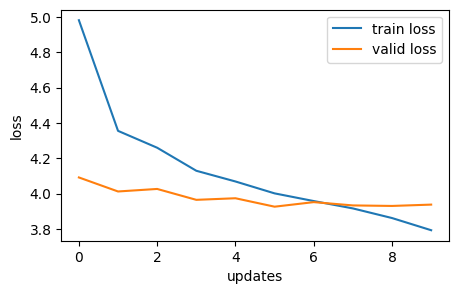

In [257]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [258]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.953 | Test PPL:  52.108 |


In [259]:
model

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(370, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): MultiplicativeAttention(
      (W): Linear(in_features=512, out_features=1024, bias=True)
    )
    (embedding): Embedding(458, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=458, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## 7. Test on some random news

In [260]:
test[0][SRC_LANGUAGE]

'Did you get that thesis from the Dude?'

In [261]:
test[0][TRG_LANGUAGE]

'คุณได้ข้อเสนอนี้ จากเพื่อนคนนั้นเหรอ?'

In [262]:
src_text = text_transform[SRC_LANGUAGE](test[0][SRC_LANGUAGE]).to(device)
src_text

tensor([ 2,  0,  6, 53, 15,  0, 64,  8,  0,  9,  3], device='cuda:0')

In [263]:
trg_text = text_transform[TRG_LANGUAGE](test[0][TRG_LANGUAGE]).to(device)
trg_text

tensor([  2,   8,  11,   0,  52,   4,  50, 167,  41,  40,  54,  19,   3],
       device='cuda:0')

In [264]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [265]:
trg_text = trg_text.reshape(-1, 1)

In [266]:
src_text.shape, trg_text.shape

(torch.Size([11, 1]), torch.Size([13, 1]))

In [267]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [268]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [269]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([13, 1, 458])

Since batch size is 1, we just take off that dimension

In [270]:
output = output.squeeze(1)

In [271]:
output.shape

torch.Size([13, 458])

We shall remove the first token since it's zeroes anyway

In [272]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([12, 458])

Then we just take the top token with highest probabilities

In [273]:
output_max = output.argmax(1) #returns max indices

In [274]:
output_max

tensor([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3], device='cuda:0')

Get the mapping of the target language

In [275]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [276]:
for token in output_max:
    print(mapping[token.item()])

<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<eos>
<eos>
<eos>
<eos>
<eos>


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [277]:
attentions.shape

torch.Size([13, 1, 11])

In [278]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](test[0][SRC_LANGUAGE]) + ['<eos>']
src_tokens

['<sos>',
 'Did',
 'you',
 'get',
 'that',
 'thesis',
 'from',
 'the',
 'Dude',
 '?',
 '<eos>']

In [279]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>']

In [280]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_27588\59549304.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Admin\AppData\Local\Temp\ipykernel_27588\59549304.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


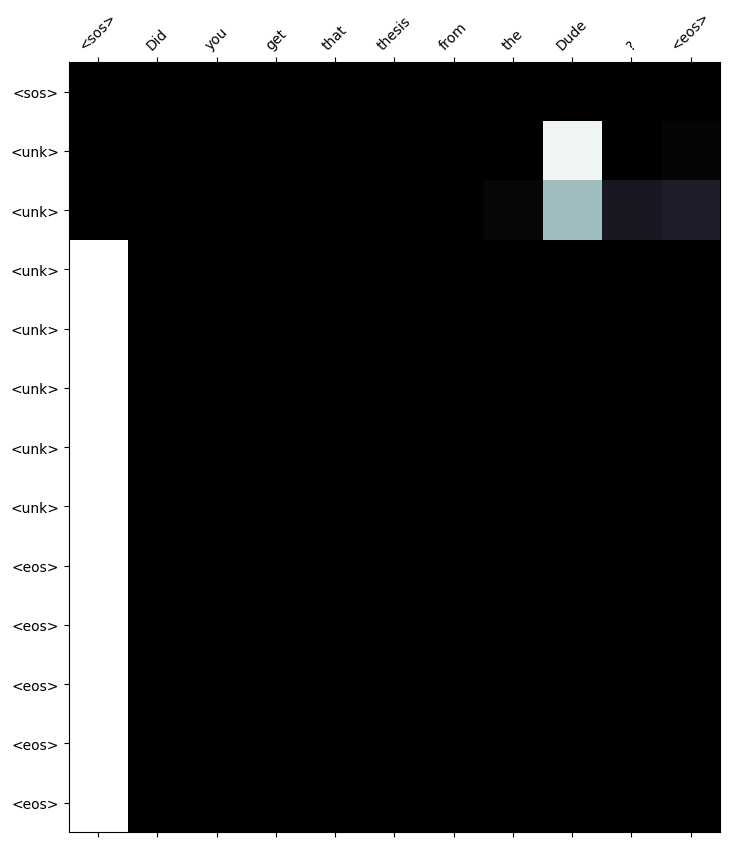

In [281]:
display_attention(src_tokens, trg_tokens, attentions)